<a href="https://colab.research.google.com/github/claitonp/tech-challenge/blob/main/tech_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tech Challenge - Fase 1

- Modelo preditivo de custos em plano de saúde

# Itens abordados:

* 1 - Análise exploratória dos dados
* 2 - Regressao linear simples
* 3 - Modelo baseado em árvore (DecisionTreeRegressor)
* 4 - Modelo baseado em árvore (RandomForestRegressor)
* 5 - Usando StandardScaler no modelo RandomForestRegressor




# Atributos:

- **age**: idade

- **sex**: Sexo

- **bmi**: indice de massa corporal

- **children**: número de filhos

- **smoker**: fumante

- **region**: região

- **charges**: gasto com o plano de saúde

In [14]:
import pandas as pd

import seaborn as sb


# **Necessário** fazer o upload .csv

In [5]:

dados = pd.read_csv("insurance.csv")

# 1 - Análise exploratória dos dados

In [ ]:
dados.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
dados.shape

(1338, 7)

In [7]:
dados.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
dados.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [9]:
dados.groupby('sex').describe()

age                                                         bmi  \
        count       mean        std   min   25%   50%    75%   max  count   
sex                                                                         
female  662.0  39.503021  14.054223  18.0  27.0  40.0  51.75  64.0  662.0   
male    676.0  38.917160  14.050141  18.0  26.0  39.0  51.00  64.0  676.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
sex                ...                                                     
female  30.377749  ...      2.0  5.0   662.0  12569.578844  11128.703801   
male    30.943129  ...      2.0  5.0   676.0  13956.751178  12971.025915   

                                                                     
              min        25%         50%           75%          max  
sex                                                                  
female  1607.5101  4885.1587  9412.96250  14454.691825  63770.42801  
male    1121.8739  4619.1340  9369.61575  18989.590250  62592.87309  

[2 rows x 32 columns]

In [10]:
dados.groupby('smoker').describe()

age                                                          bmi  \
         count       mean        std   min    25%   50%   75%   max   count   
smoker                                                                        
no      1064.0  39.385338  14.083410  18.0  26.75  40.0  52.0  64.0  1064.0   
yes      274.0  38.514599  13.923186  18.0  27.00  38.0  49.0  64.0   274.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
smoker             ...                                                     
no      30.651795  ...      2.0  5.0  1064.0   8434.268298   5993.781819   
yes     30.708449  ...      2.0  5.0   274.0  32050.231832  11541.547176   

                                                                          
               min           25%          50%           75%          max  
smoker                                                                    
no       1121.8739   3986.438700   7345.40530  11362.887050  36910.60803  
yes     12829.4551  20826.244213  34456.34845  41019.207275  63770.42801  

[2 rows x 32 columns]

In [11]:
dados.groupby('region').describe()

age                                                         bmi  \
           count       mean        std   min    25%   50%   75%   max  count   
region                                                                         
northeast  324.0  39.268519  14.069007  18.0  27.00  39.5  51.0  64.0  324.0   
northwest  325.0  39.196923  14.051646  19.0  26.00  39.0  51.0  64.0  325.0   
southeast  364.0  38.939560  14.164585  18.0  26.75  39.0  51.0  64.0  364.0   
southwest  325.0  39.455385  13.959886  19.0  27.00  39.0  51.0  64.0  325.0   

                      ... children      charges                              \
                mean  ...      75%  max   count          mean           std   
region                ...                                                     
northeast  29.173503  ...      2.0  5.0   324.0  13406.384516  11255.803066   
northwest  29.199785  ...      2.0  5.0   325.0  12417.575374  11072.276928   
southeast  33.355989  ...      2.0  5.0   364.0  14735.411438  13971.098589   
southwest  30.596615  ...      2.0  5.0   325.0  12346.937377  11557.179101   

                                                                          
                 min          25%           50%         75%          max  
region                                                                    
northeast  1694.7964  5194.322288  10057.652025  16687.3641  58571.07448  
northwest  1621.3402  4719.736550   8965.795750  14711.7438  60021.39897  
southeast  1121.8739  4440.886200   9294.131950  19526.2869  63770.42801  
southwest  1241.5650  4751.070000   8798.593000  13462.5200  52590.82939  

[4 rows x 32 columns]

In [ ]:
dados.groupby('children').describe()

age                                                         sex  \
          count       mean        std   min    25%   50%   75%   max  count   
children                                                                      
0         574.0  38.444251  16.436228  18.0  22.00  36.0  55.0  64.0  574.0   
1         324.0  39.453704  12.067445  18.0  30.00  40.0  49.0  64.0  324.0   
2         240.0  39.445833  11.588715  18.0  30.00  40.0  48.0  64.0  240.0   
3         157.0  41.566879  12.206174  18.0  31.00  41.0  52.0  64.0  157.0   
4          25.0  39.000000  12.138094  18.0  29.00  39.0  48.0  61.0   25.0   
5          18.0  35.611111  10.123583  19.0  28.75  39.0  42.5  52.0   18.0   

                    ... region      charges                              \
              mean  ...    75%  max   count          mean           std   
children            ...                                                   
0         0.496516  ...    2.0  3.0   574.0  12365.975602  12023.293942   
1         0.512346  ...    2.0  3.0   324.0  12731.171832  11823.631451   
2         0.504167  ...    2.0  3.0   240.0  15073.563734  12891.368347   
3         0.509554  ...    2.0  3.0   157.0  15355.318367  12330.869484   
4         0.560000  ...    3.0  3.0    25.0  13850.656311   9139.223321   
5         0.555556  ...    3.0  3.0    18.0   8786.035247   3808.435525   

                                                                          
                min          25%          50%           75%          max  
children                                                                  
0         1121.8739  2734.421150   9856.95190  14440.123825  63770.42801  
1         1711.0268  4791.643175   8483.87015  15632.052050  58571.07448  
2         2304.0022  6284.939438   9264.97915  20379.276748  49577.66240  
3         3443.0640  6652.528800  10600.54830  19199.944000  60021.39897  
4         4504.6624  7512.267000  11033.66170  17128.426080  40182.24600  
5         4687.7970  5874.973900   8589.56505  10019.943975  19023.26000  

[6 rows x 48 columns]

<Axes: xlabel='age', ylabel='Count'>

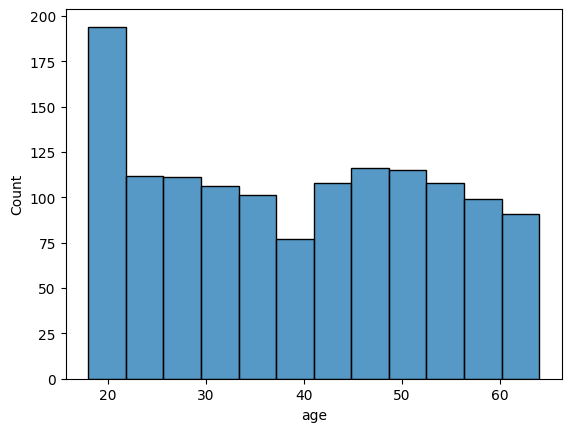

In [ ]:
sb.histplot(data=dados, x="age")

<Axes: xlabel='children', ylabel='Count'>

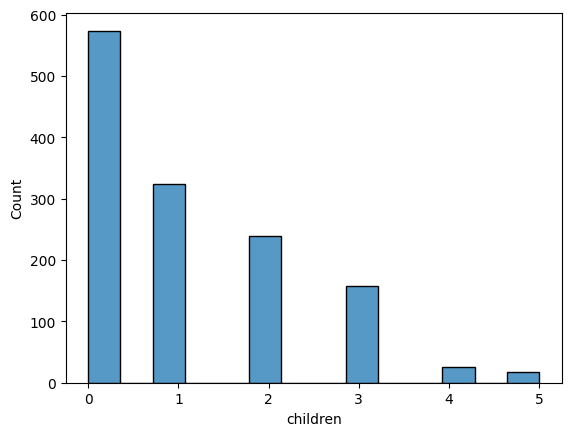

In [ ]:
sb.histplot(data=dados, x="children")

<Axes: xlabel='bmi', ylabel='Count'>

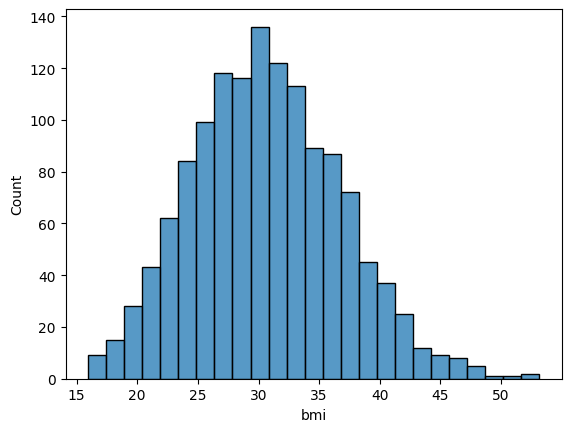

In [ ]:
sb.histplot(data=dados, x="bmi")

<ipython-input-14-f53d60a028e2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='age', y='charges', data=dados, palette='hls')


<Axes: xlabel='age', ylabel='charges'>

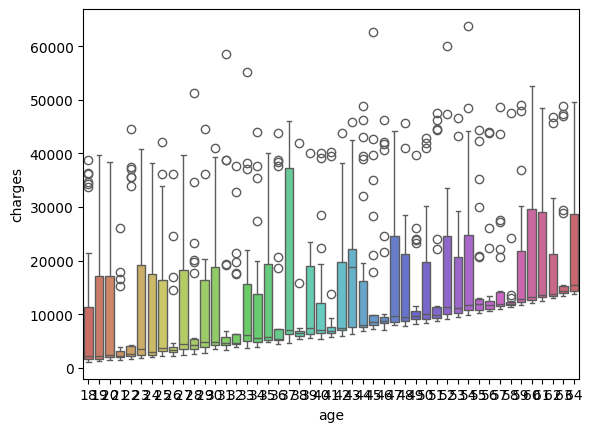

In [ ]:
sb.boxplot(x='age', y='charges', data=dados, palette='hls')

Pode ser observado nesse gráfico, a relação da idade e dos gastos, que com o avanço da idade os gastos vão aumentando....

<ipython-input-15-63abe1d98588>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='smoker', y='charges', data=dados, palette='hls')


<Axes: xlabel='smoker', ylabel='charges'>

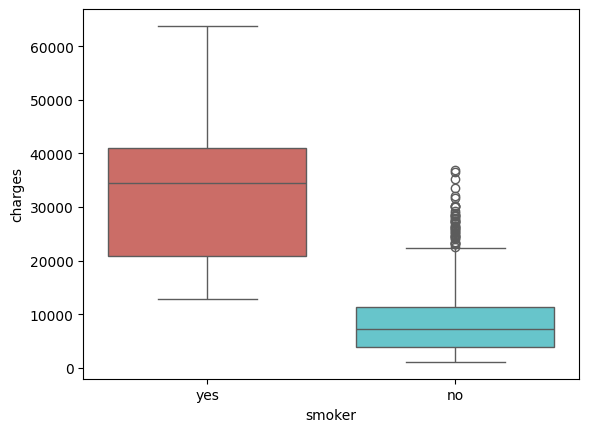

In [ ]:
sb.boxplot(x='smoker', y='charges', data=dados, palette='hls')

Nesse gráfico pode ser observado que o fumante tem um gasto maior, em relação ao não fumante.

<ipython-input-272-cce2b2571798>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='sex', y='charges', data=dados, palette='hls')


<Axes: xlabel='sex', ylabel='charges'>

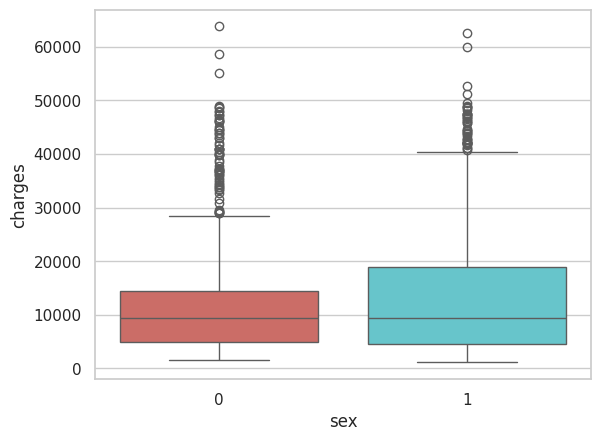

In [272]:
sb.boxplot(x='sex', y='charges', data=dados, palette='hls')

<Axes: xlabel='charges'>

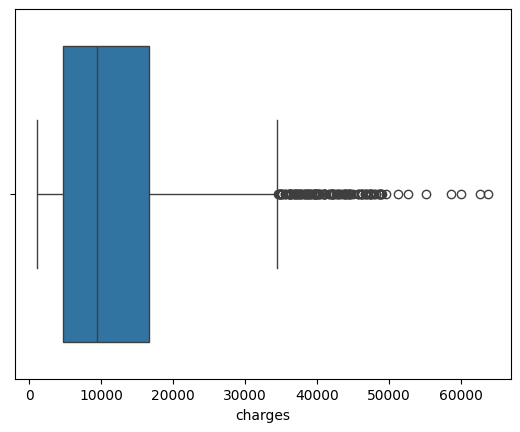

In [ ]:
sb.boxplot(x=dados["charges"])

<Axes: xlabel='bmi'>

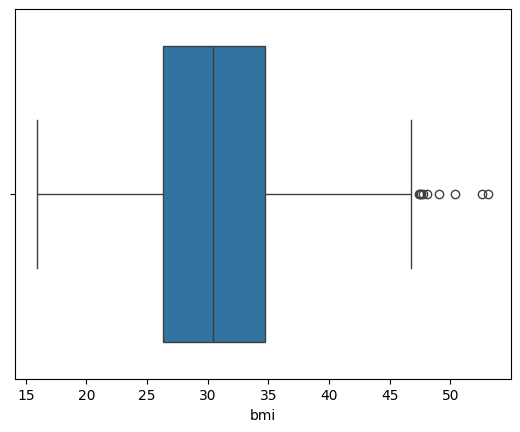

In [ ]:
sb.boxplot(x=dados["bmi"])

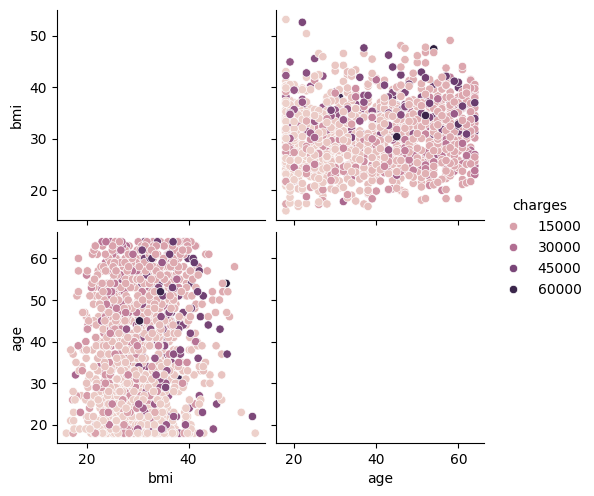

In [17]:
sb.pairplot(dados,vars=['bmi','age'],hue="charges")

Nesses gráficos, pode ser observar que quanto maior o bmi (indice de massa corportal) maior o gasto com o plano de saúde, o mesmo com  avanço da idade.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 20.0% of the points cannot be plac

[Text(13.000000000000002, 0.5, '')]

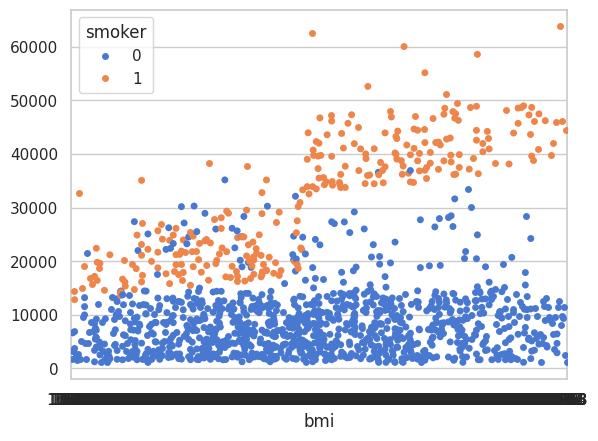

In [ ]:

sb.set_theme(style="whitegrid", palette="muted")

ax = sb.swarmplot(data=dados, x="bmi", y="charges", hue="smoker")
ax.set(ylabel="")

Aqui neste gráfico (smoker,bmi e charges), pode perceber que fumantes tem mais gastos com o plano de saude e quanto mais alto IMC o gasto vai aumentando


Vamos utilizar label enconder para tratar variáveis categoricas que possuem apenas dois tipos de categorias, como genero, especialização e status.

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
colunas=['sex','smoker','region']

label_encoder = LabelEncoder()
for col in colunas:
    dados[col] = label_encoder.fit_transform(dados[col])
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


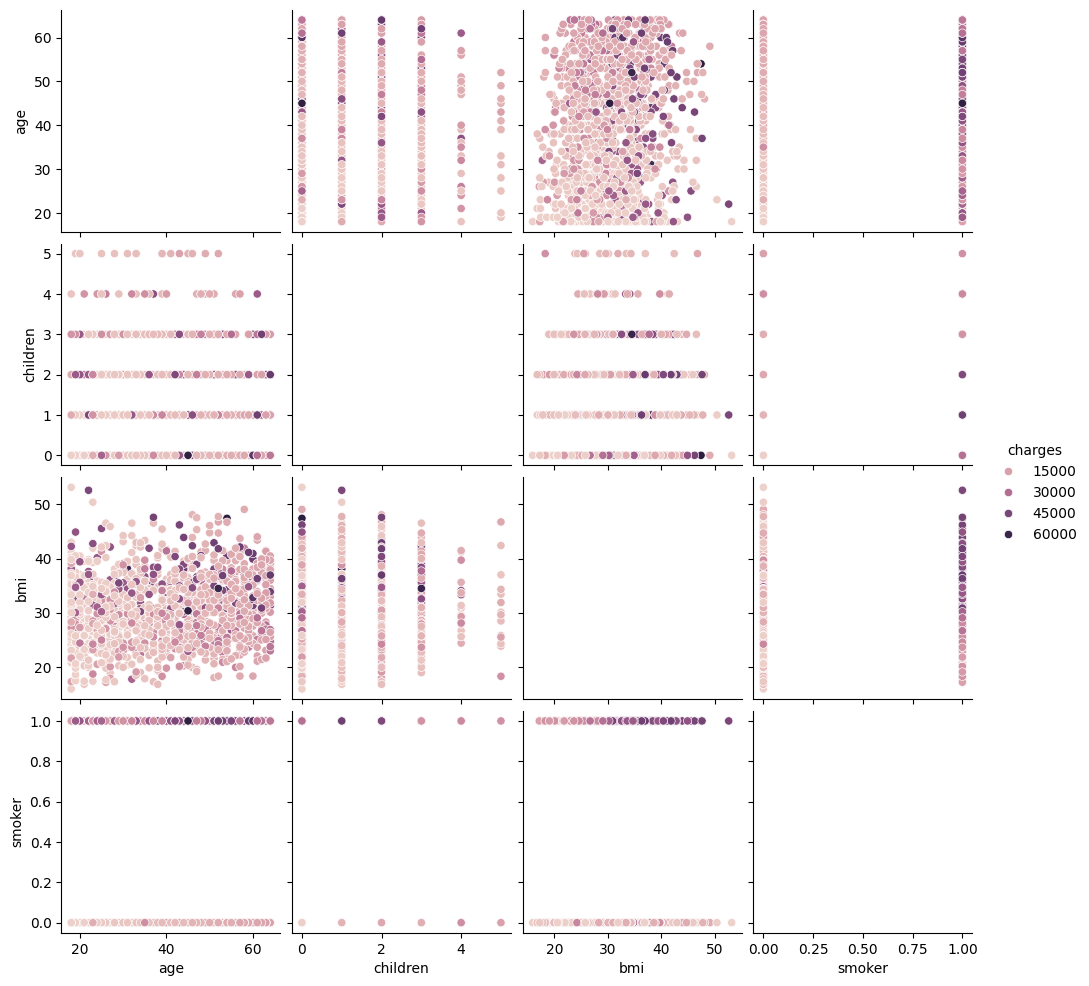

In [22]:
sb.pairplot(dados,vars=['age','children','bmi','smoker'],hue="charges")

<Axes: >

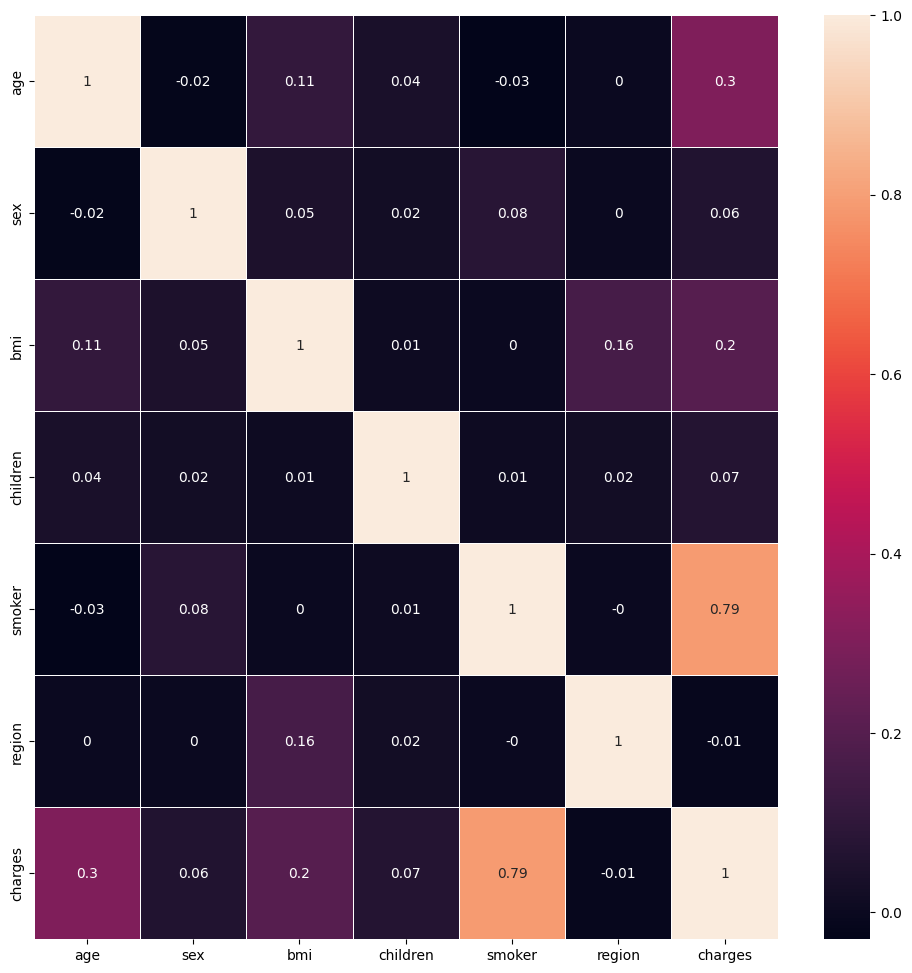

In [ ]:
import matplotlib.pyplot as plt

correlation_matrix = dados.corr().round(2)
fig, ax = plt.subplots(figsize=(12,12))
sb.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

pode ser percebido que a correlação dos gastos com a pessoa fumante é alta de 0,79 e com bmi de 0,20 e de idade 0,3

In [ ]:

correlation_matrix = dados.corr()
max_corr = correlation_matrix.stack().sort_values(ascending=False).drop_duplicates()
max_corr = max_corr[max_corr < 1].head(10)

print("Maior correlação:")
print(max_corr)

Maior correlação:
smoker    charges     0.787251
charges   age         0.299008
bmi       charges     0.198341
region    bmi         0.157566
bmi       age         0.109272
sex       smoker      0.076185
charges   children    0.067998
sex       charges     0.057292
bmi       sex         0.046371
children  age         0.042469
dtype: float64


# 2 - Regressao linear simples - - - - - - - - - - - - - - - - - - -


In [189]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [191]:

# Selecionando as features e o target
X = dados[['age', 'bmi', 'sex', 'smoker', 'region', 'children']]
y = dados['charges']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando um modelo de regressão linear
model = LinearRegression()

# Treinando o modelo
model.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
y_pred = model.predict(X_test)

# Avaliando o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)

erro_absoluto_medio = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print(f'Erro Absoluto Médio: {erro_absoluto_medio}')
print("R-squared:", r2)

Mean Squared Error: 33635210.431178406
Erro Absoluto Médio: 4186.508898366435
R-squared: 0.7833463107364539


Em resumo, o modelo de regressão linear parece ter um desempenho razoável, explicando cerca de 78,3% da variabilidade nos custos médicos com base nas variáveis incluídas.

MSE ? Não entendi

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

(268, 6)
(268,)
(268,)


In [ ]:
import matplotlib.pyplot as plt

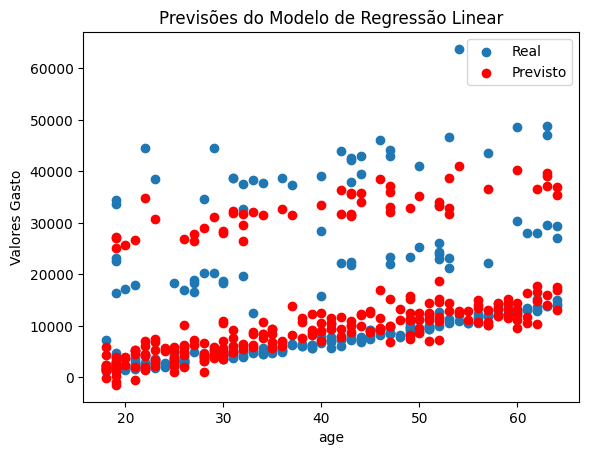

In [ ]:
# Visualizando as previsões

feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo de Regressão Linear')
plt.legend()
plt.show()

# 3 - Modelo baseado em árvore (DecisionTreeRegressor) - - - - - - - - - - - - - - -

> Adicionar aspas



In [222]:
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

<Axes: >

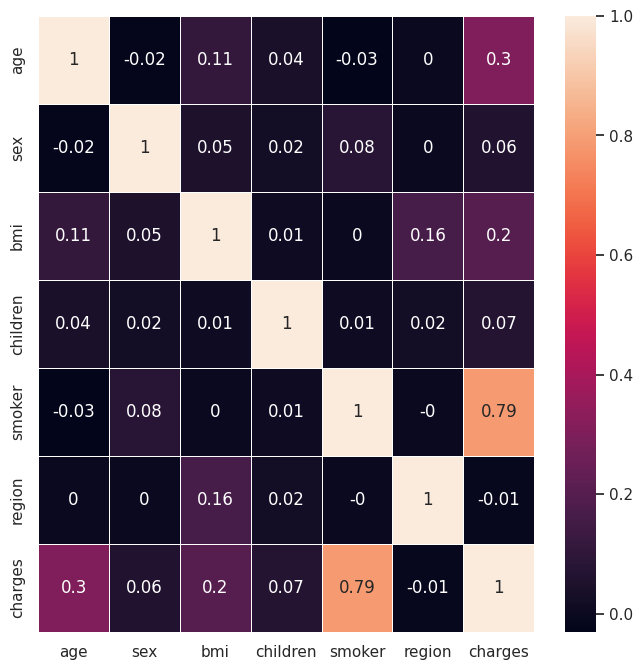

In [160]:
correlation_matrix = dados.corr().round(2)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)


In [201]:
# Selecionando as features e o target
X = dados[['age', 'bmi', 'sex', 'smoker', 'region', 'children']]
y = dados['charges']

In [256]:
X

,age,bmi,sex,smoker,region,children
0,19,27.900,0,1,3,0
1,18,33.770,1,0,2,1
2,28,33.000,1,0,2,3
3,33,22.705,1,0,1,0
4,32,28.880,1,0,1,0
...,...,...,...,...,...,...
1333,50,30.970,1,0,1,3
1334,18,31.920,0,0,0,0
1335,18,36.850,0,0,2,0
1336,21,25.800,0,0,3,0


In [237]:
#Separando em bases de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [238]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_predito = dt.predict(X_test)

In [239]:
y_predito = dt.predict(X_test)

In [253]:
# Avaliando o desempenho do modelo
mse = mean_squared_error(y_test, y_predito)

erro_absoluto_medio = mean_absolute_error(y_test, y_predito)
r2 = r2_score(y_test, y_predito)

print("Mean Squared Error:", mse)
print(f'Erro Absoluto Médio: {erro_absoluto_medio}')
print("R-squared:", r2)

Mean Squared Error: 49458356.671421945
Erro Absoluto Médio: 3198.264822820896
R-squared: 0.6814250512955546


In [242]:
print (rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9748046793870697
0.8639393567618504


O **score** nos dá uma visão da precisão média da floresta aleatória nos dados fornecidos

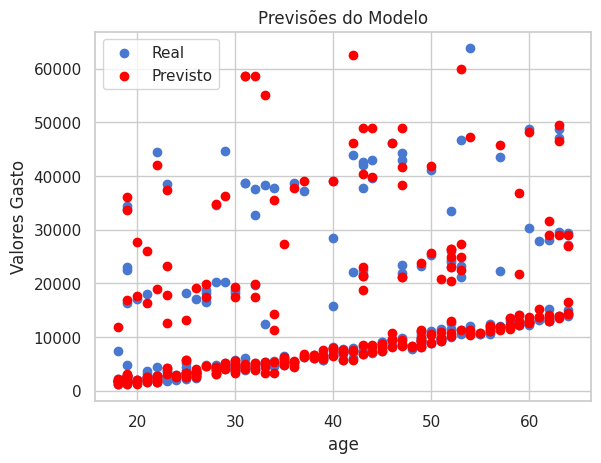

In [243]:
# Visualizando as previsões

feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_predito, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 4 - Modelo baseado em árvore (RandomForestRegressor) - - - - - - - - - - - - - -

In [223]:
rf = RandomForestRegressor()

In [244]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [225]:
estimator = rf.estimators_

In [245]:
y_predito_random_forest = rf.predict(X_test)

In [252]:
# Avaliando o desempenho do modelo
mse = mean_squared_error(y_test, y_predito_random_forest)

erro_absoluto_medio = mean_absolute_error(y_test, y_predito_random_forest)
r2 = r2_score(y_test, y_predito_random_forest)

print("Mean Squared Error:", mse)
print(f'Erro Absoluto Médio: {erro_absoluto_medio}')
print("R-squared:", r2)

Mean Squared Error: 20914619.96423269
Erro Absoluto Médio: 2446.423361133116
R-squared: 0.8652831507010352


In [247]:
print (rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9750722613679501
0.8652831507010352


O **score** nos dá uma visão da precisão média da floresta aleatória nos dados fornecidos

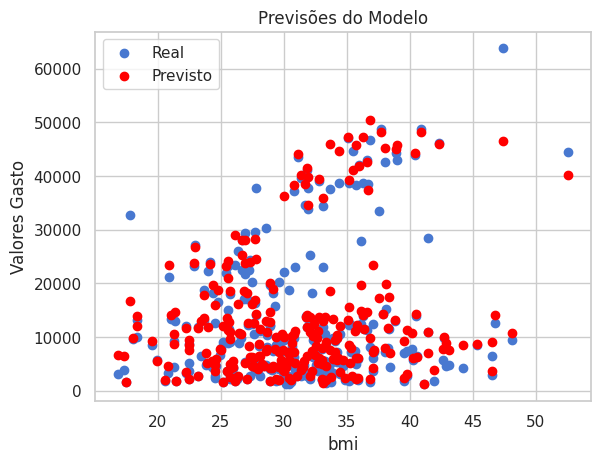

In [255]:
# Visualizando as previsões

feature = 'bmi'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_predito_random_forest, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 5 - Usando StandardScaler - RandomForestRegressor - - - - - - -

In [261]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [266]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [267]:
y_predito_random_forest_scaled = rf.predict(X_test_scaled)

In [268]:
# Avaliando o desempenho do modelo
mse = mean_squared_error(y_test, y_predito_random_forest_scaled)

erro_absoluto_medio = mean_absolute_error(y_test, y_predito_random_forest_scaled)
r2 = r2_score(y_test, y_predito_random_forest_scaled)

print("Mean Squared Error:", mse)
print(f'Erro Absoluto Médio: {erro_absoluto_medio}')
print("R-squared:", r2)

Mean Squared Error: 20659883.364539444
Erro Absoluto Médio: 2454.733167438123
R-squared: 0.8669239795647915


Não há melhoras no modelo, usando StandardScaler